In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [85]:
df = pd.read_csv('../input/realpunjab/punjab_real.csv')
df = df.set_index('Timestamp')
df.index = pd.to_datetime(df.index)

In [86]:
df.head()

,demand
Timestamp,
2022-04-01 00:00:00,33.6872
2022-04-01 00:15:00,36.4328
2022-04-01 00:30:00,45.1000
2022-04-01 00:45:00,42.8848
2022-04-01 01:00:00,44.3392


# 1. Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

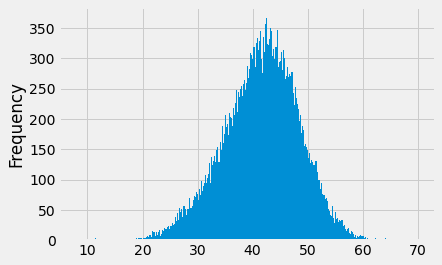

In [87]:
df['demand'].plot(kind='hist', bins=500)

In [88]:
df = df.query('demand > 20').copy()
df = df.query('demand < 60').copy()

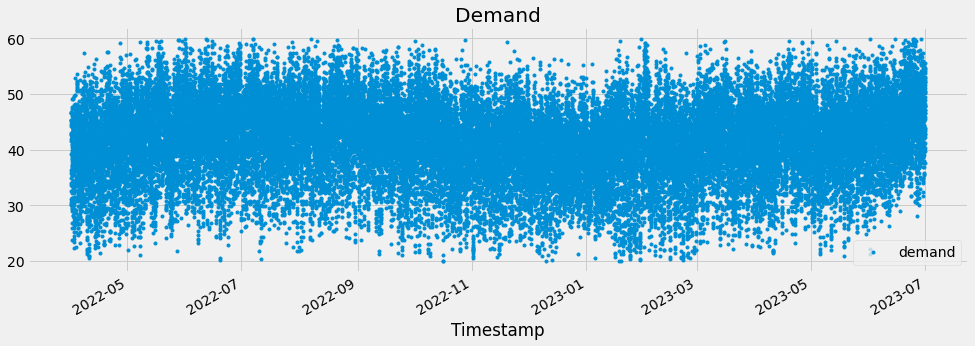

In [89]:
df.plot(style = '.',
       figsize = (15,5),
       color = color_pal[0],
       title = 'Demand')
plt.show()

# Reviewing: Train / Test Split

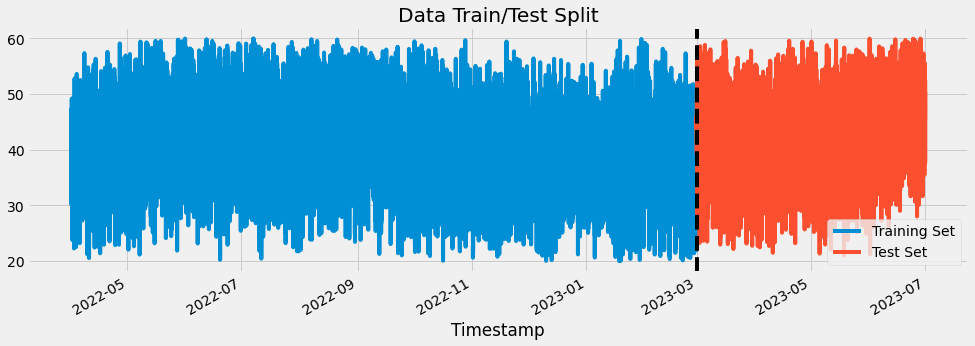

In [90]:
train = df.loc[df.index<'03-01-2023']
test = df.loc[df.index>='03-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('03-01-2023', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [91]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=4*24, gap=4)
df = df.sort_index()

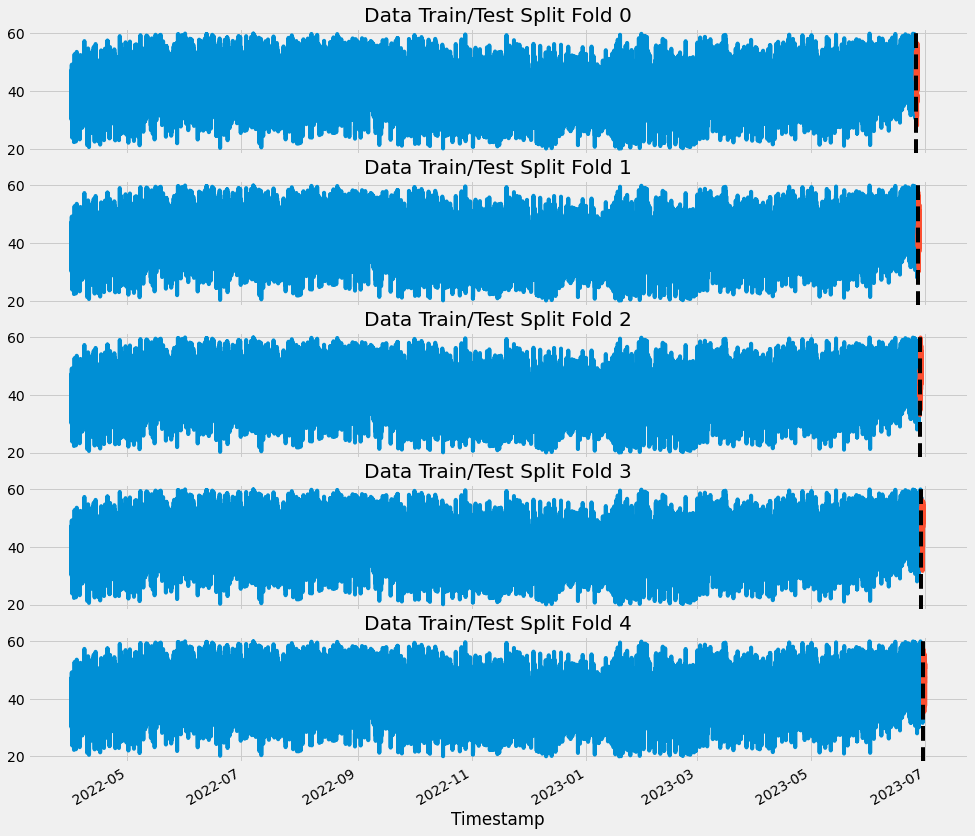

In [92]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [93]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['mins'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [94]:
def add_lags(df):
    target_map = df['demand'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('84 days')).map(target_map)
    return df

In [95]:
df = add_lags(df)

## Train Using Cross Validation

In [96]:
tss = TimeSeriesSplit(n_splits=5, test_size=4*24, gap=4)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_absolute_percentage_error(y_test, y_pred))
    scores.append(score)

[10:58:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.16432	validation_1-rmse:42.79616
[100]	validation_0-rmse:15.85868	validation_1-rmse:17.11048
[200]	validation_0-rmse:7.47496	validation_1-rmse:8.01595
[300]	validation_0-rmse:5.36077	validation_1-rmse:5.17673
[400]	validation_0-rmse:4.95108	validation_1-rmse:4.44355
[500]	validation_0-rmse:4.85141	validation_1-rmse:4.27740
[600]	validation_0-rmse:4.80698	validation_1-rmse:4.21109
[700]	validation_0-rmse:4.77495	validation_1-rmse:4.18233
[800]	validation_0-rmse:4.74753	validation_1-rmse:4.17387
[900]	validation_0-rmse:4.72427	validation_1-rmse:4.16585
[956]	validation_0-rmse:4.71206	validation_1-rmse:4.17207
[10:58:50] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.16743	validation_1-rmse:44.78940
[100]	validation_0-rmse:15.85903	validation_1-rmse:19.25339
[200

In [97]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.2955
Fold scores:[0.2781387952132459, 0.285113633811667, 0.3122102712836561, 0.2836304161253875, 0.31823207758756045]


In [21]:
def absolute_error_obj(alpha):
    def absolute_error(labels, predt):
        x = predt - labels
        grad = np.sign(x) 
        grad[np.abs(x) < alpha] = 2/alpha*x[np.abs(x) < alpha]
        hess = np.zeros_like(labels) 
        hess[np.abs(x) < alpha] = 2/alpha
        return grad, hess
    return absolute_error

tss = TimeSeriesSplit(n_splits=5, test_size=4*24, gap=4)
df = df.sort_index()


fold1 = 0
preds1 = []
scores1 = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg1 = xgb.XGBRegressor(n_estimators=2000, max_depth=7, 
                     eta=0.05, subsample=0.7, colsample_bytree=0.8)
    reg1.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred1 = reg1.predict(X_test)
    preds1.append(y_pred1)
    score1 = np.sqrt(mean_absolute_percentage_error(y_test, y_pred1))
    scores1.append(score1)

[0]	validation_0-rmse:39.53264	validation_1-rmse:41.12464
[100]	validation_0-rmse:4.21060	validation_1-rmse:4.44733
[200]	validation_0-rmse:3.92237	validation_1-rmse:5.42029
[300]	validation_0-rmse:3.75640	validation_1-rmse:5.64210
[400]	validation_0-rmse:3.62061	validation_1-rmse:5.88992
[500]	validation_0-rmse:3.50460	validation_1-rmse:5.96445
[600]	validation_0-rmse:3.40659	validation_1-rmse:6.06171
[700]	validation_0-rmse:3.31163	validation_1-rmse:5.97577
[800]	validation_0-rmse:3.22579	validation_1-rmse:6.01391
[900]	validation_0-rmse:3.15039	validation_1-rmse:6.04463
[1000]	validation_0-rmse:3.07203	validation_1-rmse:6.08742
[1100]	validation_0-rmse:3.00122	validation_1-rmse:6.17680
[1200]	validation_0-rmse:2.93213	validation_1-rmse:6.21488
[1300]	validation_0-rmse:2.86481	validation_1-rmse:6.19412
[1400]	validation_0-rmse:2.79753	validation_1-rmse:6.24356
[1500]	validation_0-rmse:2.73775	validation_1-rmse:6.26520
[1600]	validation_0-rmse:2.67763	validation_1-rmse:6.28134
[1700]	

In [24]:
scores2 = []
preds2 = []
y_pred2 = reg1.predict(X_test)
preds2.append(y_pred2)
score2 = np.sqrt(mean_squared_error(y_test, y_pred2))
scores2.append(score2)
    
print(f'Score across folds {np.mean(scores2):0.4f}')
print(f'Fold scores:{scores2}')

Score across folds 5.4981
Fold scores:[5.498054257725965]


In [22]:
print(f'Score across folds {np.mean(scores1):0.4f}')
print(f'Fold scores:{scores1}')

Score across folds 0.3062
Fold scores:[0.3744196288210887, 0.28992211019102176, 0.31001303739623065, 0.2562279943306429, 0.30047437646557273]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [104]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'mins', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'demand'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=900,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[11:03:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.20925
[100]	validation_0-rmse:15.87667
[200]	validation_0-rmse:7.48753
[300]	validation_0-rmse:5.36948
[400]	validation_0-rmse:4.95360
[500]	validation_0-rmse:4.84952
[600]	validation_0-rmse:4.80571
[700]	validation_0-rmse:4.76937
[800]	validation_0-rmse:4.74119
[899]	validation_0-rmse:4.71734


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [105]:
df.index.max()

Timestamp('2023-06-30 23:45:00')

In [106]:
df.index.min()

Timestamp('2022-04-01 00:00:00')

In [117]:
# Create future dataframe
future = pd.date_range('2022-07-01','2023-06-30', freq='15min')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [114]:
future_w_features = df_and_future.query('isFuture').copy()

In [124]:
df_new = df.loc[df.index>='07-01-2022']
df_new.head()

,demand,mins,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Timestamp,,,,,,,,,,,,,,
2022-07-01 00:00:00,37.8552,0,0,4,3,7,2022,182,1,26,40.2544,39.5768,39.8088,False
2022-07-01 00:15:00,37.4352,15,0,4,3,7,2022,182,1,26,43.6064,38.8808,40.6616,False
2022-07-01 00:30:00,40.2232,30,0,4,3,7,2022,182,1,26,41.0440,40.5472,43.0032,False
2022-07-01 00:45:00,40.7696,45,0,4,3,7,2022,182,1,26,43.2552,42.2544,44.2304,False
2022-07-01 01:00:00,41.9088,0,1,4,3,7,2022,182,1,26,40.7680,51.2728,49.7672,False


## Predict the future

In [125]:
df_new['pred'] = reg.predict(df_new[FEATURES])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
df_new.head()

,demand,mins,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
Timestamp,,,,,,,,,,,,,,,
2022-07-01 00:00:00,37.8552,0,0,4,3,7,2022,182,1,26,40.2544,39.5768,39.8088,False,41.709328
2022-07-01 00:15:00,37.4352,15,0,4,3,7,2022,182,1,26,43.6064,38.8808,40.6616,False,41.966442
2022-07-01 00:30:00,40.2232,30,0,4,3,7,2022,182,1,26,41.0440,40.5472,43.0032,False,43.139030
2022-07-01 00:45:00,40.7696,45,0,4,3,7,2022,182,1,26,43.2552,42.2544,44.2304,False,44.644142
2022-07-01 01:00:00,41.9088,0,1,4,3,7,2022,182,1,26,40.7680,51.2728,49.7672,False,45.396473


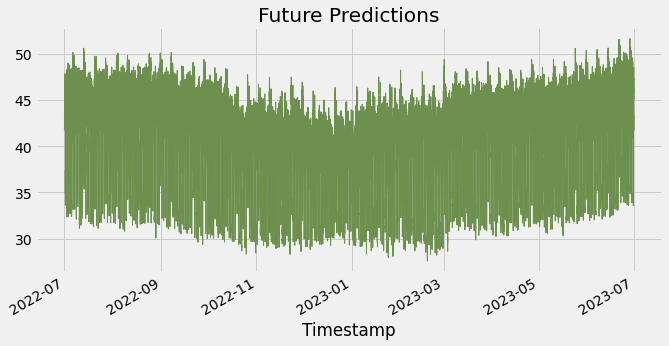

In [128]:
df_new['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

plt.show()

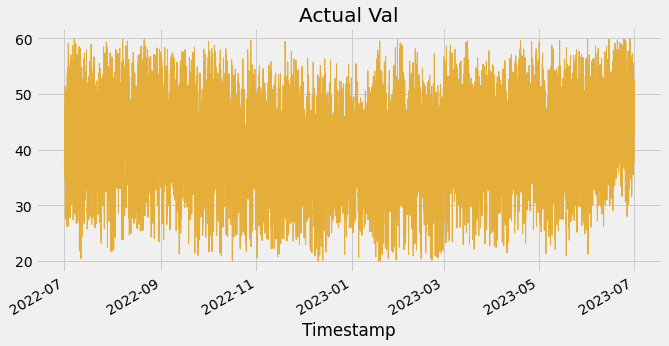

In [129]:
df_new['demand'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=1,
                               lw=1,
                               title='Actual Val')
plt.show()

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

# The End